In [38]:
import sys
import os

import pandas as pd
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
import anndata
import seaborn as sns
import torch
import matplotlib.font_manager
from matplotlib import rcParams
font_list = []
fpaths = matplotlib.font_manager.findSystemFonts()
for i in fpaths:
    try:
        f = matplotlib.font_manager.get_font(i)
        font_list.append(f.family_name)
    except RuntimeError:
        pass

font_list = set(font_list)
plot_font = 'Helvetica' if 'Helvetica' in font_list else 'FreeSans'
rcParams['font.family'] = plot_font
rcParams.update({'font.size': 10})
rcParams.update({'figure.dpi': 300})
rcParams.update({'figure.figsize': (3,3)})
rcParams.update({'savefig.dpi': 500})

%load_ext autoreload
%autoreload 2

sys.path.append('../')
import sample_squidiff

import plot_util 

import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
sampler = sample_squidiff.sampler(
    model_path = 'simu_results/model.pt',
    gene_size = 100,
    output_dim = 100,
    use_drug_structure = False
)

load model and diffusion...
diffusion num of steps =  1000


In [40]:
test_adata_scrna = sc.read_h5ad('datasets/sc_simu_test.h5ad')
z_sem_scrna = sampler.model.encoder(torch.tensor(test_adata_scrna.X).to('cuda'))

scrnas_pred = sampler.pred(z_sem_scrna, gene_size = test_adata_scrna.shape[1])

x_T = sampler.stochastic_encode(sampler.model,
                  x = torch.tensor(test_adata_scrna.X, dtype = torch.float32).to('cuda'),
                  t = 999,
                  model_kwargs={'x_start':torch.tensor(test_adata_scrna.X, dtype = torch.float32).to('cuda'),
                                'z_mod':z_sem_scrna,
                                }
                 )['sample']

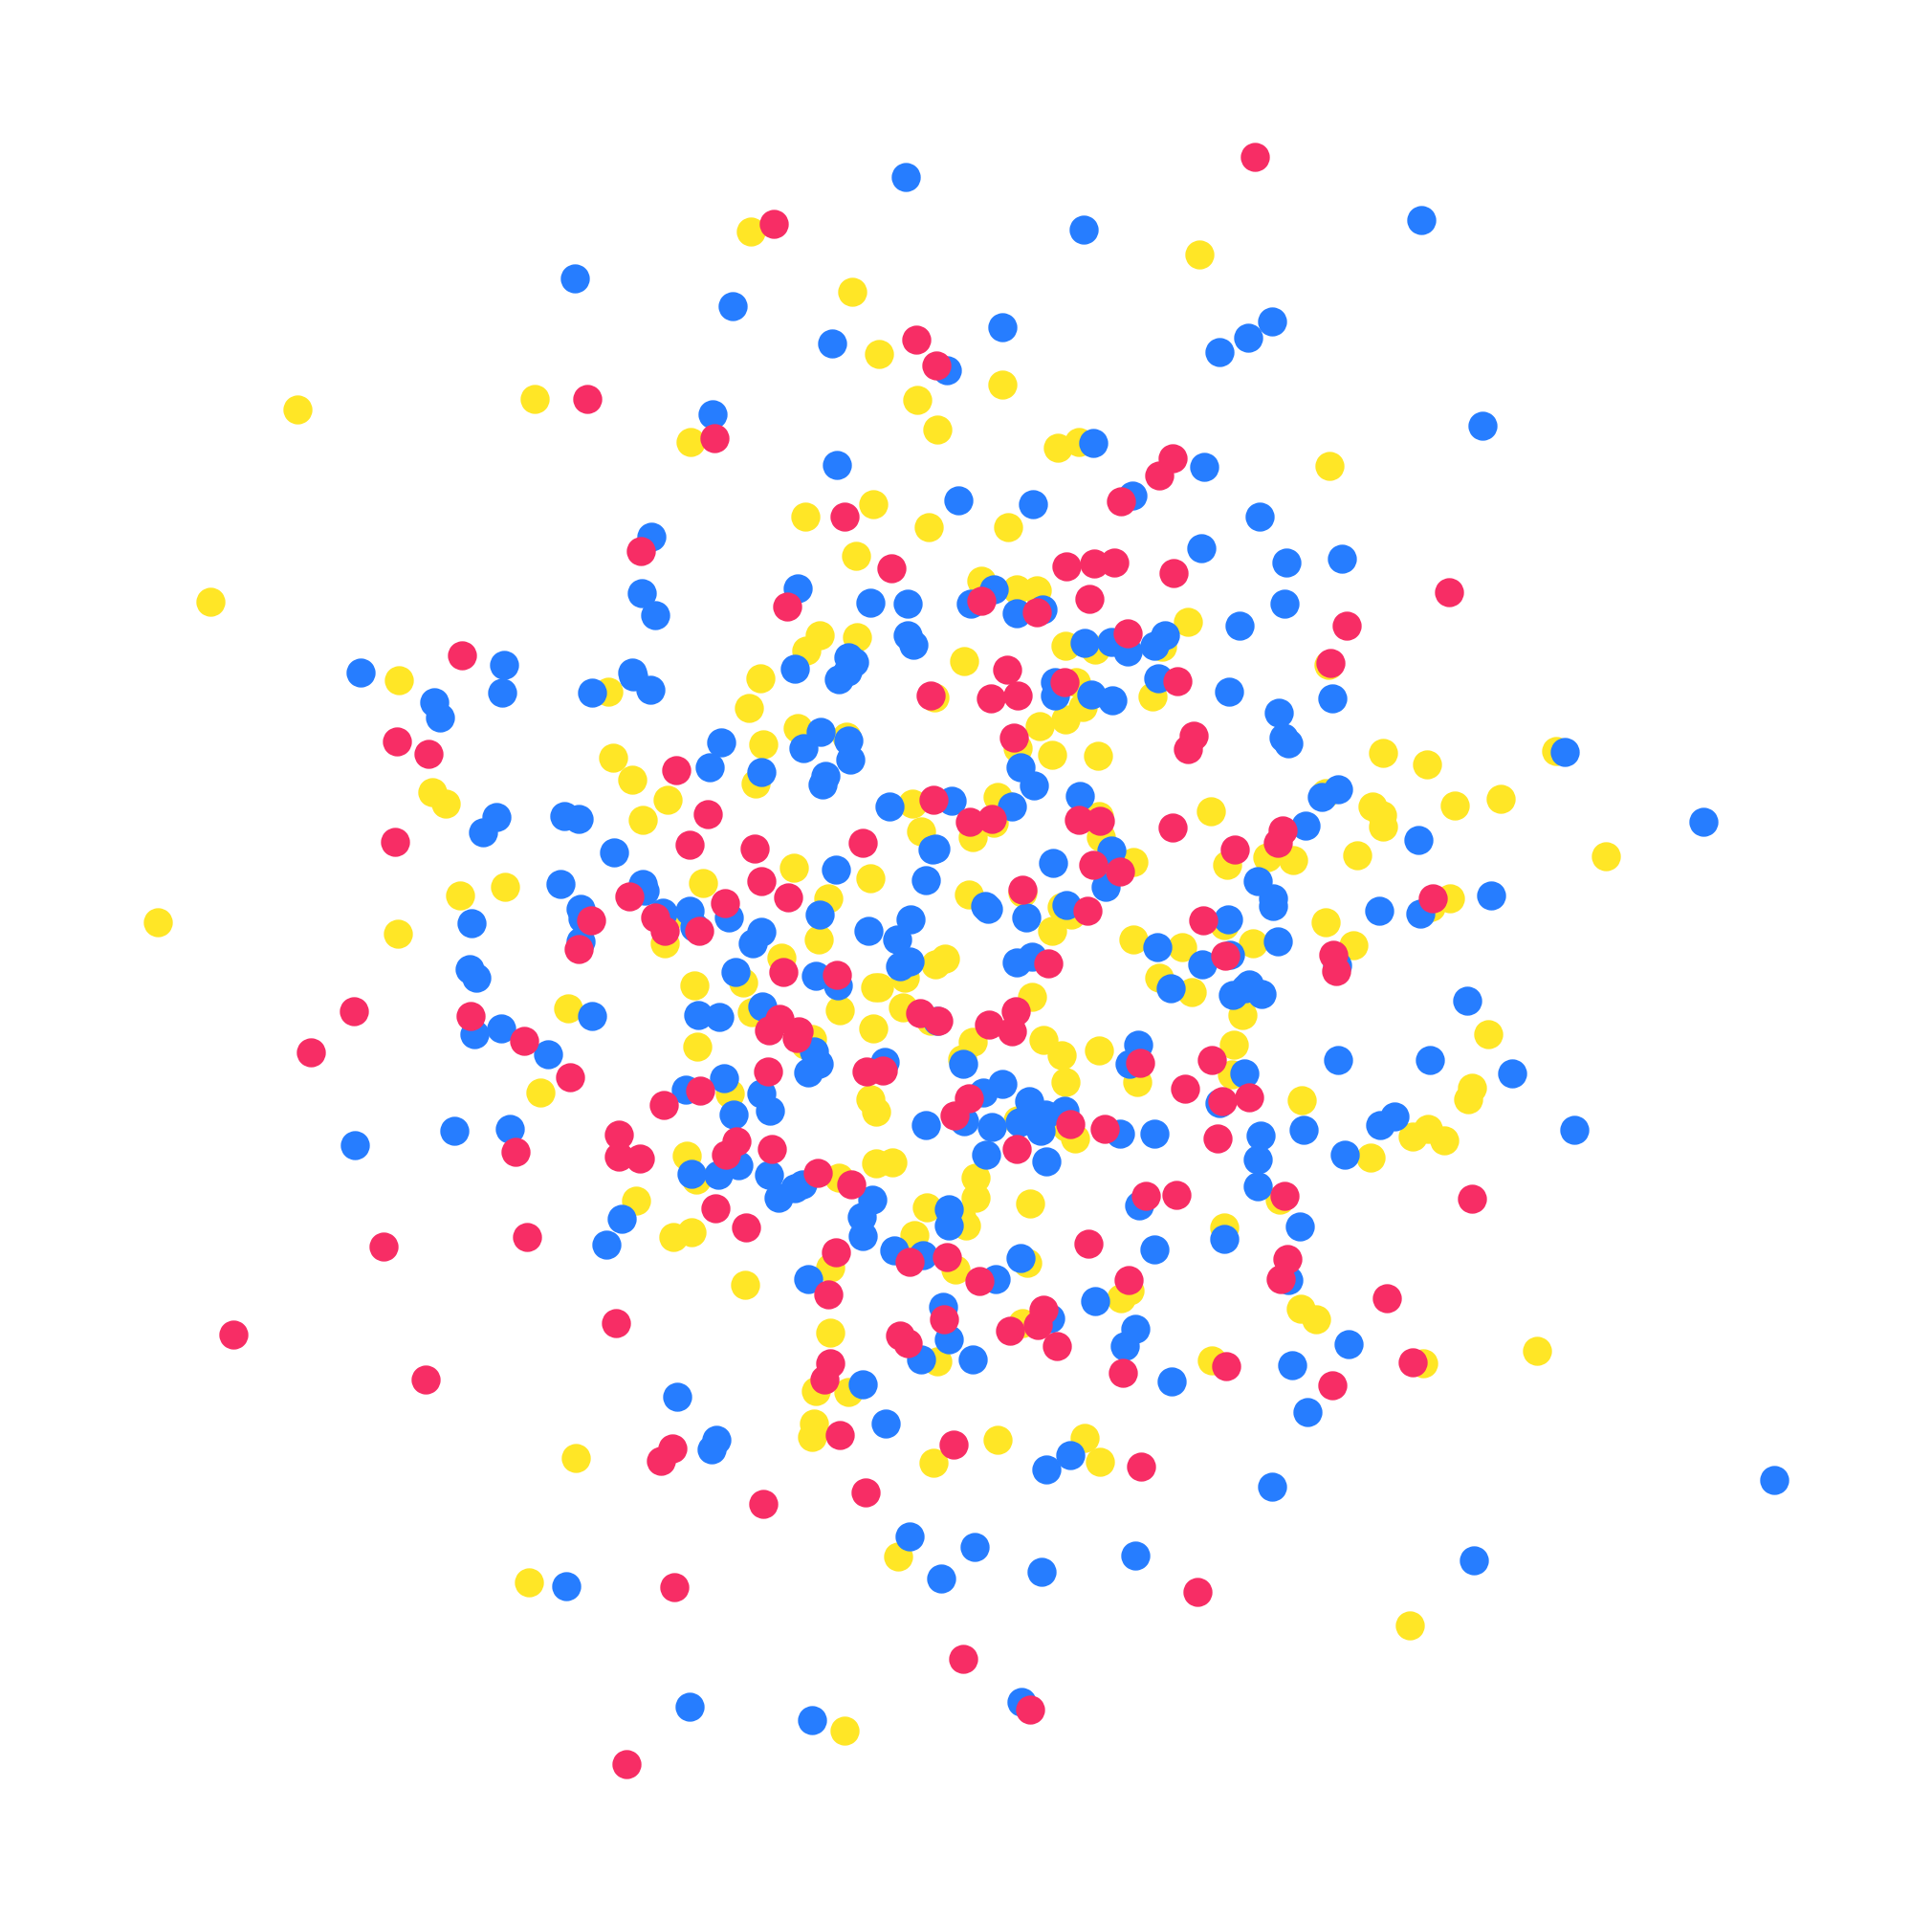

In [41]:
plot_util.plot_pca(x_T, 
                    label = test_adata_scrna.obs['Group'],
                    size = 3)

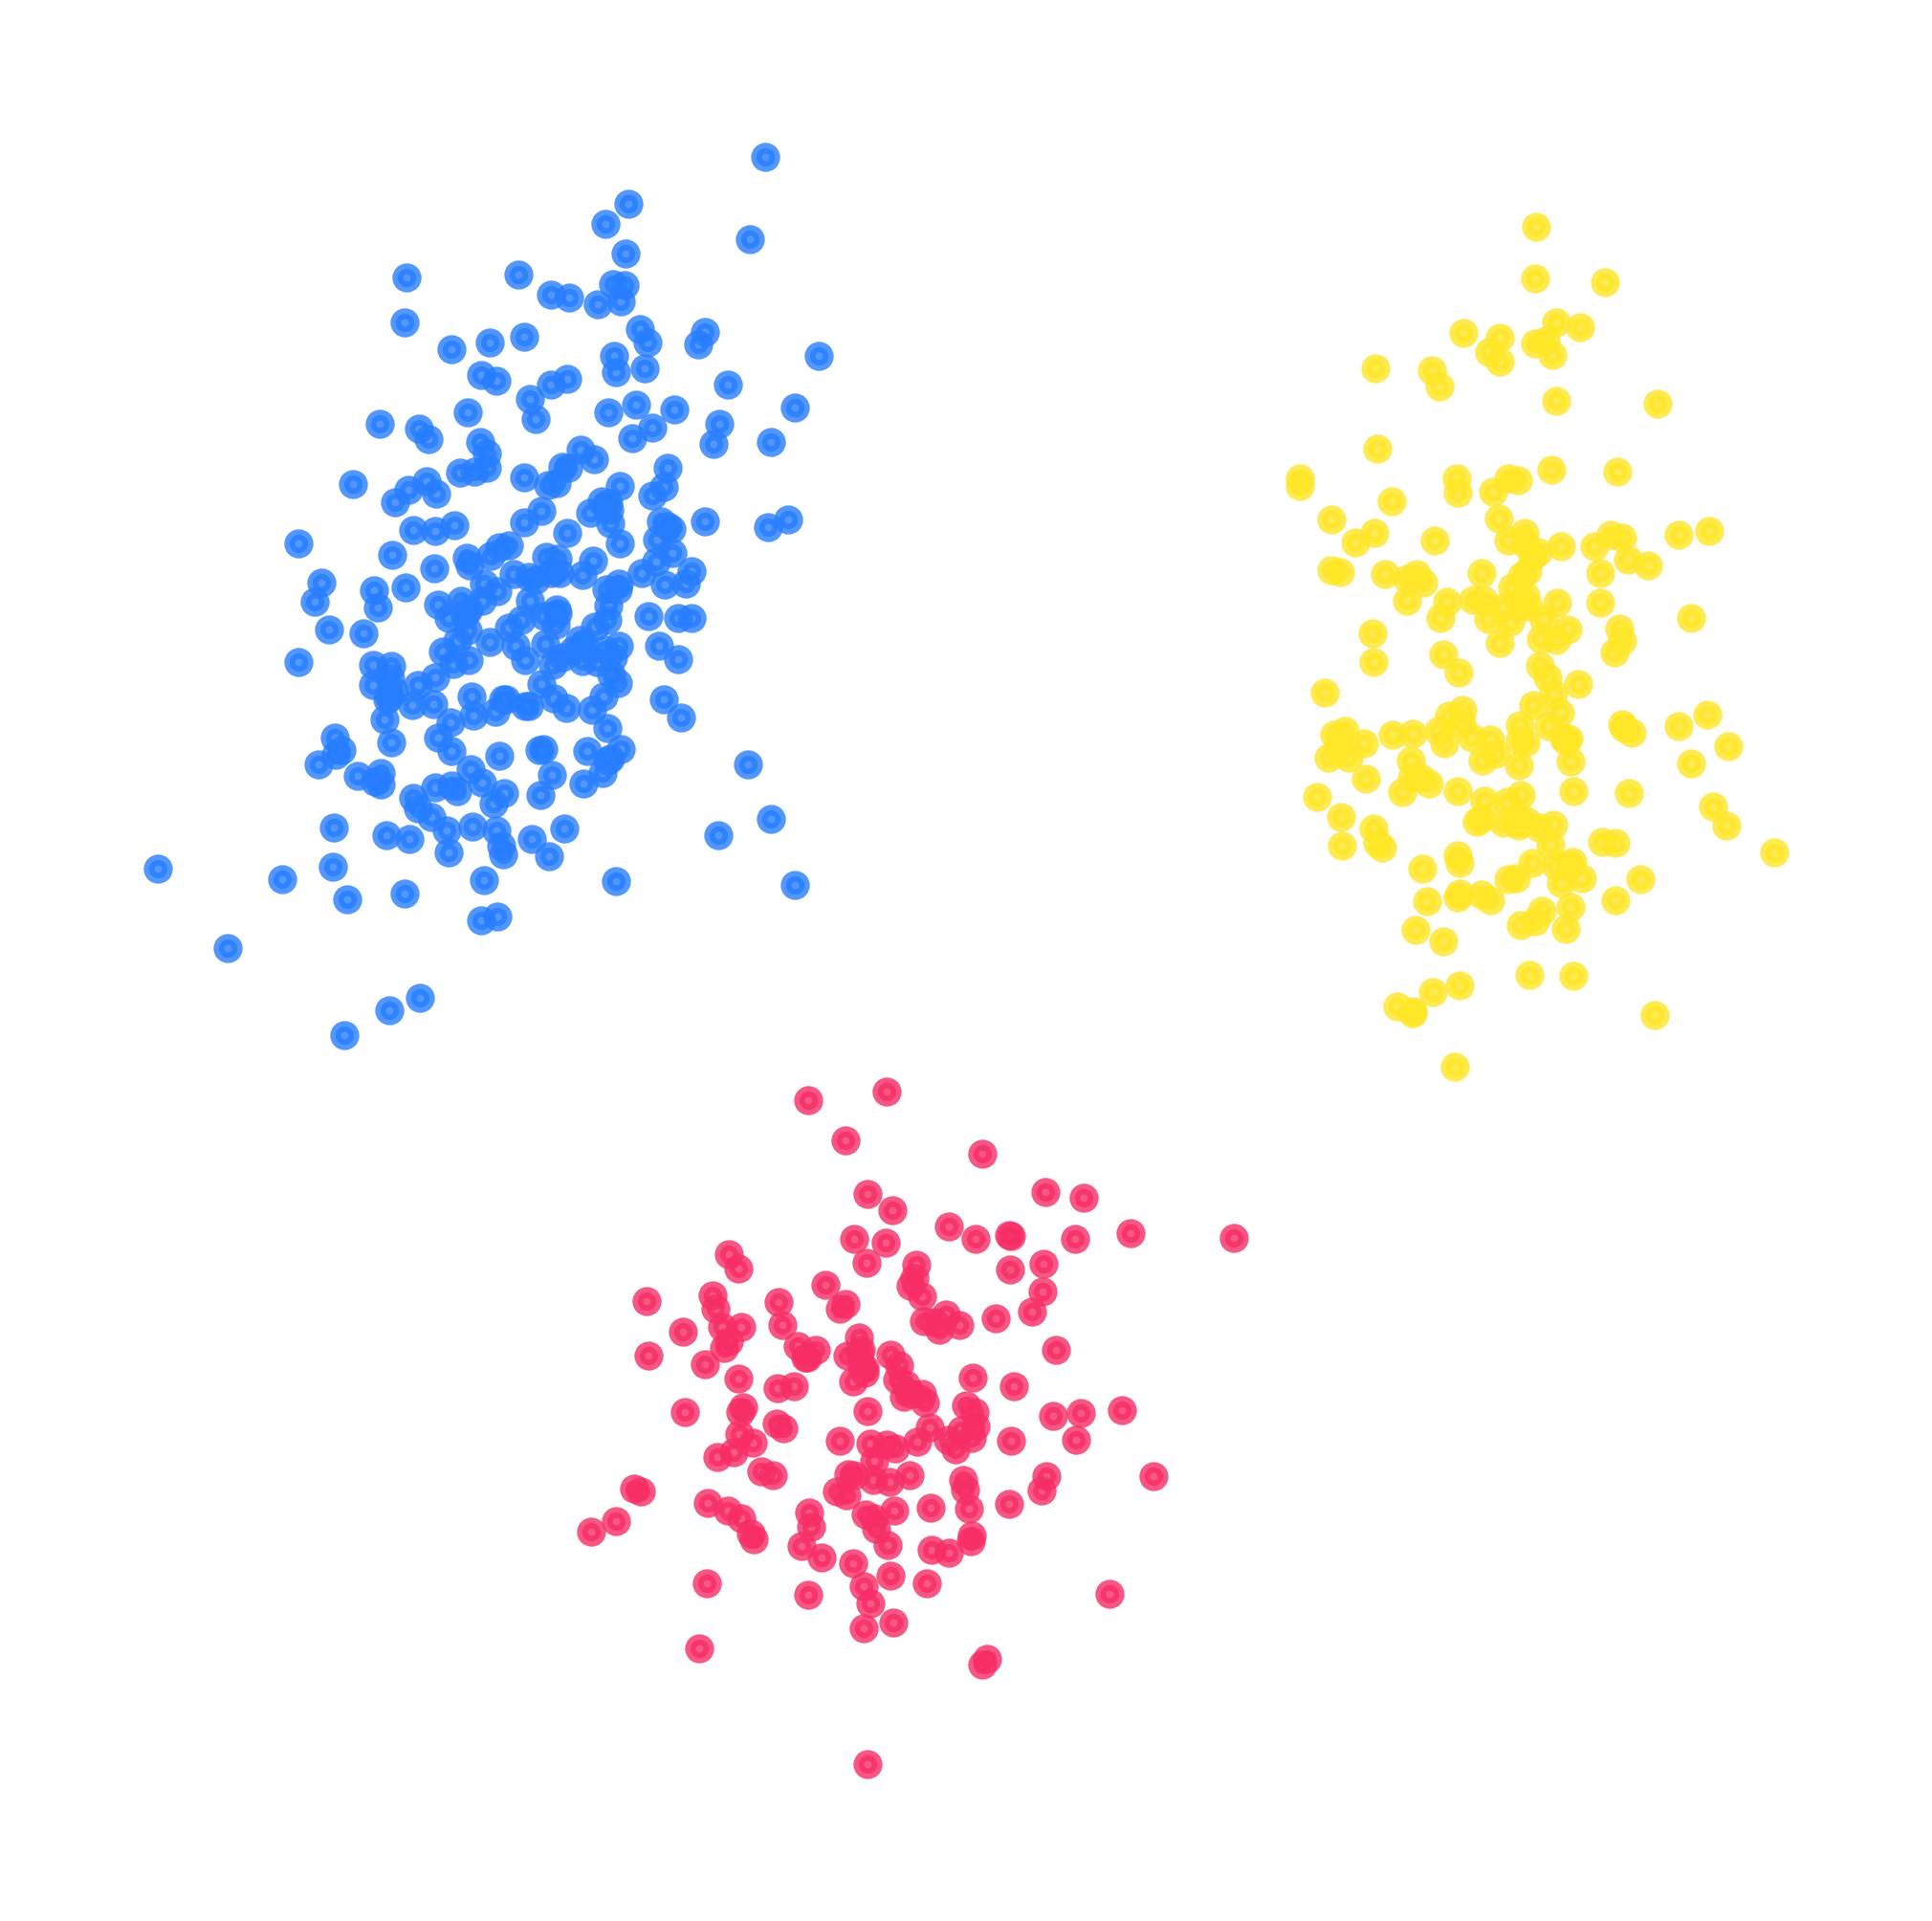

In [18]:
plot_util.plot_pca(z_sem_scrna,
                   label = test_adata_scrna.obs['Group'],
                   size = 3, alpha=0.8)

/tmp/ipykernel_1975210/4240034641.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  reconstructed_sample = scrnas_pred.detach().cpu()[test_adata_scrna.obs['Group']==1].flatten()[indices]


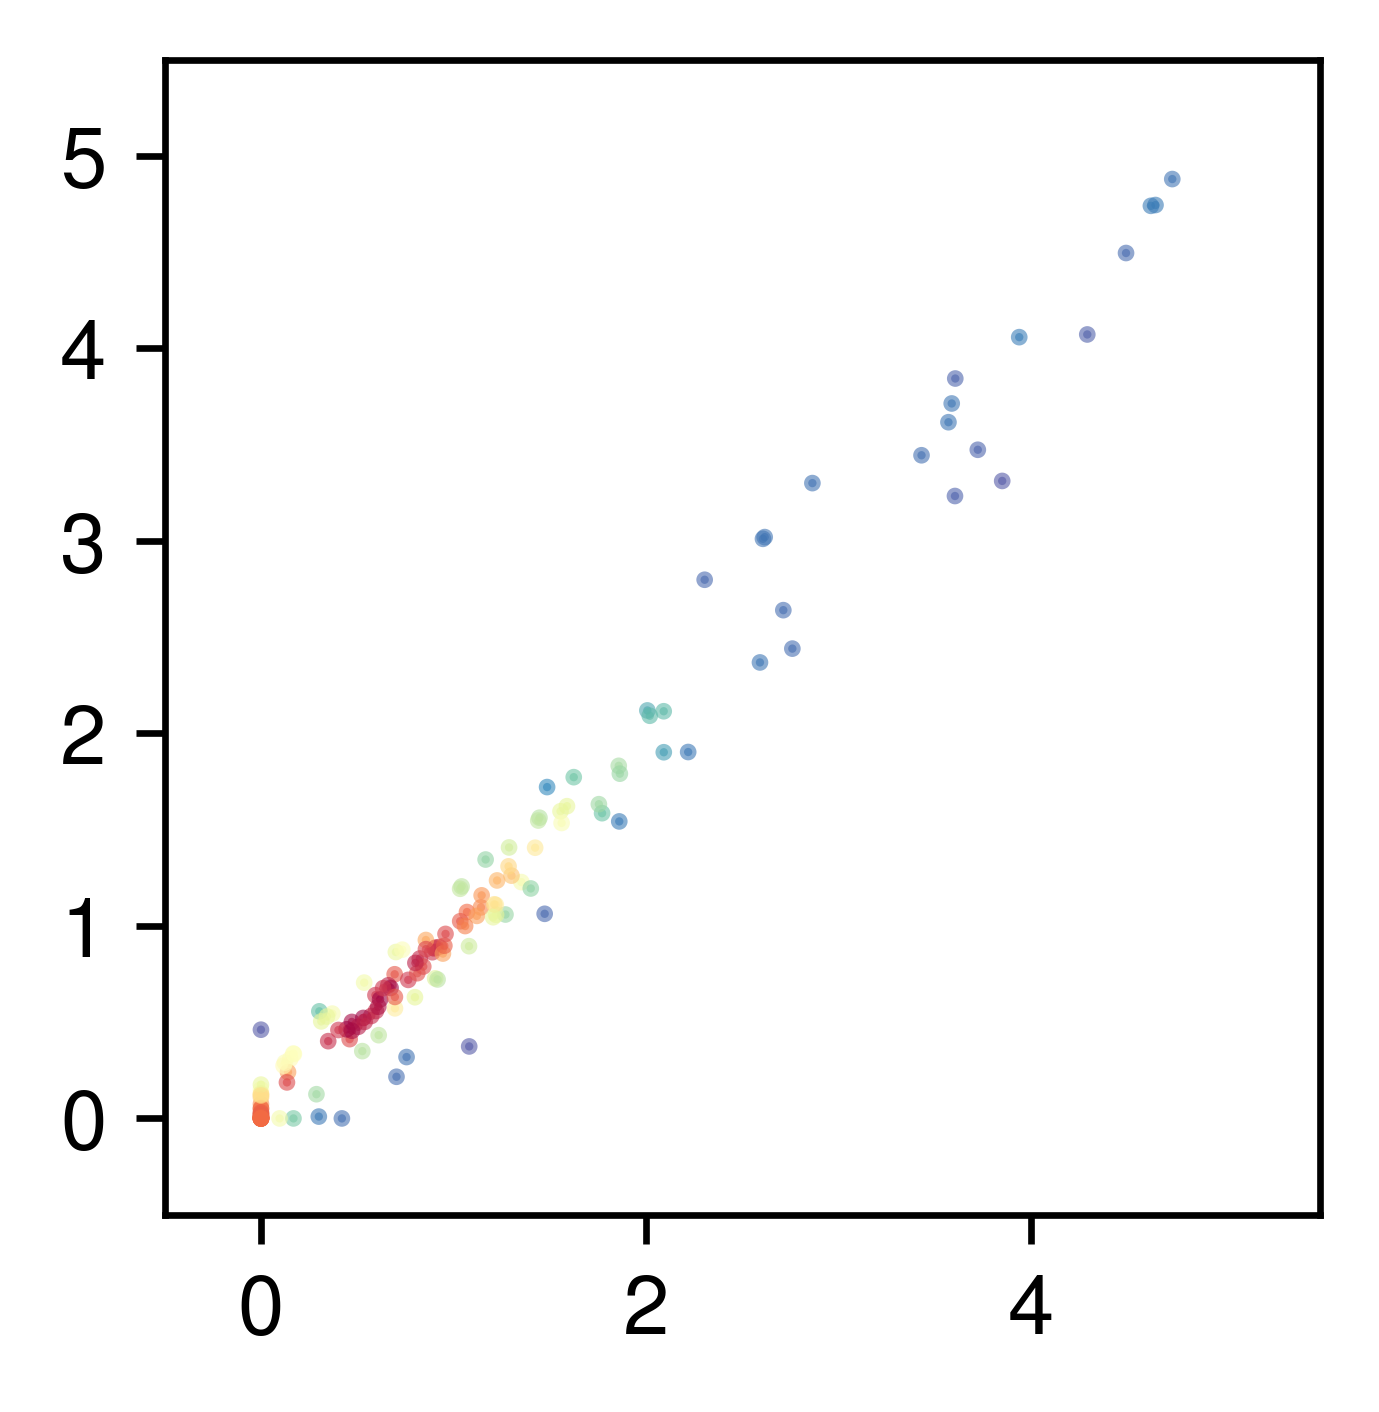

In [29]:
sample_size = 1500  # Adjust the sample size as needed
indices = np.random.choice(len(test_adata_scrna[test_adata_scrna.obs['Group']==1].X.flatten()), sample_size, replace=False)
original_sample = test_adata_scrna[test_adata_scrna.obs['Group']==1].X.flatten()[indices]
reconstructed_sample = scrnas_pred.detach().cpu()[test_adata_scrna.obs['Group']==1].flatten()[indices]

original_df = pd.DataFrame(original_sample)
reconstructed_df = pd.DataFrame(reconstructed_sample)

# Display the plot
plot_util.display_reconst(original_df, 
                reconstructed_df, 
                density=True, 
                size=(2.5,2.5))

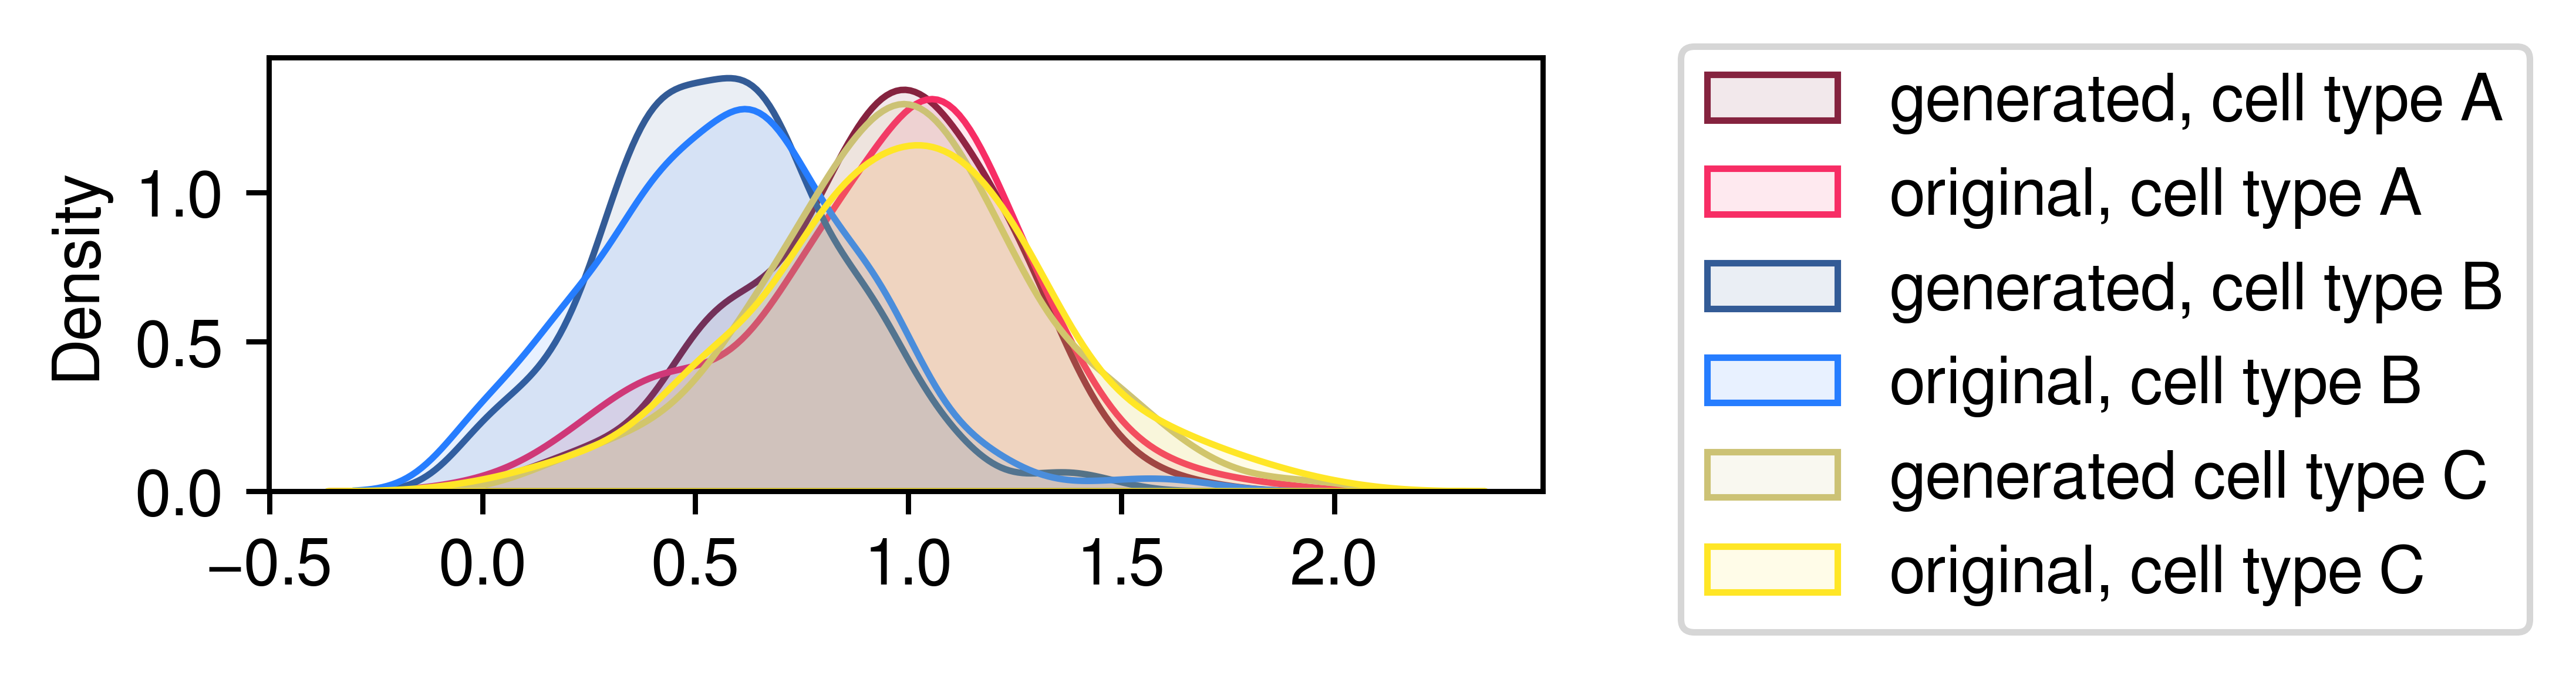

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Plot smoothed distribution of the first component for label == 1
plt.figure(figsize=(3.5, 1.2), dpi=800)
# Plot for sample_interp
gene_id = 0
label = test_adata_scrna.obs['Group'].values
sns.kdeplot(scrnas_pred.detach().cpu()[label == 3][:, gene_id], 
            label='generated, cell type A',shade=True, alpha=0.1, color = '#85233F')
# Plot for data
sns.kdeplot(test_adata_scrna.X[label == 3][:, gene_id], 
            label='original, cell type A',shade=True, alpha=0.1,  color = '#f72d65')

sns.kdeplot(scrnas_pred.detach().cpu()[label == 2][:, gene_id], 
            label='generated, cell type B',shade=True, alpha=0.1, color = '#335B96')
# Plot for data
sns.kdeplot(test_adata_scrna.X[label == 2][:, gene_id], 
            label='original, cell type B',shade=True, alpha=0.1,  color = '#267dff')


sns.kdeplot(scrnas_pred.detach().cpu()[label == 1][:, gene_id], color = '#CCC275',
            label='generated cell type C',shade=True, alpha=0.1)
# Plot for data
sns.kdeplot(test_adata_scrna.X[label == 1][:, gene_id], 
            label='original, cell type C',shade=True, alpha=0.1,   color = '#ffe626')


plt.legend(bbox_to_anchor=(1.8,1.1))
plt.show()